<a href="https://colab.research.google.com/github/Swetha455/Hospital-Management/blob/main/AI-Driven%20Risk%20Prediction%20Engine%20for%20Chronic%20Care%20Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings("ignore")


In [2]:
OUTPUT_DIR = "./risk_prediction_demo"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# -----------------------------
# 1. Synthetic data generator
# -----------------------------
def generate_synthetic_cohort(n_patients=1500, seed=0):
    np.random.seed(seed)
    rows = []
    patient_ids = [f"P{100000+i}" for i in range(n_patients)]
    for pid in patient_ids:
        age = int(np.clip(np.random.normal(68, 10), 40, 90))
        sex = np.random.choice(["M", "F"], p=[0.52, 0.48])
        has_diabetes = np.random.rand() < 0.45
        has_hf = np.random.rand() < 0.18
        baseline_bmi = np.clip(np.random.normal(28 if has_diabetes else 26, 4), 18, 45)
        n_snapshots = np.random.choice([1,2,3,4], p=[0.4,0.3,0.2,0.1])
        base_date = datetime(2024,1,1) + timedelta(days=np.random.randint(0,180))
        for s in range(n_snapshots):
            snapshot_date = base_date + timedelta(days=30*s + np.random.randint(0,15))
            hbA1c_recent = np.random.normal(7.0 + (0.6 if has_diabetes else 0.0) + np.random.normal(0,0.5), 0.6)
            hbA1c_prev = hbA1c_recent - np.random.normal(0.0, 0.3)
            eGFR = np.clip(np.random.normal(65 - (0.2*age/10), 15), 10, 120)
            eGFR_prev = eGFR + np.random.normal(0,5)
            systolic_bp = np.clip(np.random.normal(135 + (0.1*(age-60)), 12), 90, 220)
            hr = int(np.clip(np.random.normal(78,10), 45, 130))
            med_adherence_pct = np.clip(np.random.normal(0.88 - (0.2 if np.random.rand()<0.2 else 0.0), 0.12), 0, 1)
            recent_er = np.random.choice([0,1], p=[0.92,0.08])
            prior_hosp = np.random.choice([0,1], p=[0.96,0.04])
            steps_mean = int(np.clip(np.random.normal(4200 - (50*(age-60)), 2000), 200, 20000))
            risk_logit = (
                0.02*(age-60)
                + 0.6*(hbA1c_recent - 7.0)
                - 0.015*(eGFR-60)
                + 0.9*(1-med_adherence_pct)
                + 1.2*recent_er
                + 1.4*prior_hosp
                + 0.00008*(max(0, systolic_bp-140))**1.5
                - 0.00002*steps_mean
            )
            prob = 1/(1+np.exp(-risk_logit))
            prob = np.clip(prob + np.random.normal(0,0.05), 0.01, 0.95)
            label = np.random.binomial(1, prob)
            rows.append({
                "patient_id": pid,
                "snapshot_date": snapshot_date,
                "age": age,
                "sex": sex,
                "has_diabetes": int(has_diabetes),
                "has_hf": int(has_hf),
                "baseline_bmi": round(baseline_bmi,1),
                "hbA1c_recent": round(hbA1c_recent,3),
                "hbA1c_prev": round(hbA1c_prev,3),
                "hbA1c_delta": round(hbA1c_recent - hbA1c_prev,3),
                "eGFR": round(eGFR,2),
                "eGFR_prev": round(eGFR_prev,2),
                "eGFR_delta": round(eGFR - eGFR_prev,2),
                "systolic_bp": round(systolic_bp,1),
                "heart_rate": hr,
                "med_adherence": round(med_adherence_pct,3),
                "recent_er": recent_er,
                "prior_hosp": prior_hosp,
                "steps_mean": steps_mean,
                "deterioration_90d": int(label),
                "label_prob_sim": prob
            })
    df = pd.DataFrame(rows)
    df.sort_values(["patient_id","snapshot_date"], inplace=True)
    return df

# Generate dataset
print("Generating synthetic cohort...")
df = generate_synthetic_cohort(n_patients=1500, seed=42)
print("Snapshots:", len(df), "Unique patients:", df["patient_id"].nunique())


Generating synthetic cohort...
Snapshots: 2947 Unique patients: 1500


In [4]:
display(df.head())

,patient_id,snapshot_date,age,sex,has_diabetes,has_hf,baseline_bmi,hbA1c_recent,hbA1c_prev,hbA1c_delta,...,eGFR_prev,eGFR_delta,systolic_bp,heart_rate,med_adherence,recent_er,prior_hosp,steps_mean,deterioration_90d,label_prob_sim
0,P100000,2024-03-25,72,F,0,1,25.4,7.746,7.920,-0.174,...,52.83,2.86,125.1,51,0.994,0,0,1783,1,0.602424
1,P100001,2024-01-29,61,M,0,1,28.4,6.525,6.705,-0.181,...,91.50,0.07,122.4,86,0.733,0,0,4587,1,0.400596
2,P100001,2024-02-27,61,M,0,1,28.4,8.986,8.907,0.079,...,90.71,-2.30,136.1,62,0.967,0,0,398,1,0.623310
3,P100002,2024-03-23,77,F,0,0,28.7,6.649,6.981,-0.332,...,49.58,-4.06,153.0,77,0.800,0,0,6340,1,0.616369
4,P100002,2024-04-19,77,F,0,0,28.7,6.892,7.307,-0.414,...,58.95,0.30,148.2,95,0.750,0,0,6595,0,0.635527


In [5]:
# -----------------------------
# 2. Prepare features and labels
# -----------------------------
feature_cols = [
    "age", "has_diabetes", "has_hf", "baseline_bmi",
    "hbA1c_recent", "hbA1c_delta", "eGFR", "eGFR_delta",
    "systolic_bp", "heart_rate", "med_adherence", "recent_er", "prior_hosp", "steps_mean"
]
target_col = "deterioration_90d"
X = df[feature_cols].copy()
y = df[target_col].copy()
groups = df["patient_id"].copy()

# Train-test split by patient to avoid leakage
unique_patients = df["patient_id"].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=0)
train_idx = df["patient_id"].isin(train_patients)
test_idx = df["patient_id"].isin(test_patients)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print("Train/test shapes:", X_train.shape, X_test.shape)
print("Positive rate train/test:", y_train.mean(), y_test.mean())

Train/test shapes: (2366, 14) (581, 14)
Positive rate train/test: 0.6120033812341504 0.6179001721170396


In [6]:
# -----------------------------
# 3. Train and calibrate model
# -----------------------------
print("Training HistGradientBoostingClassifier...")
model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_leaf_nodes=31, random_state=0)
# holdout for calibration
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)
model.fit(X_tr_sub, y_tr_sub)
calibrator = CalibratedClassifierCV(estimator=model, method="isotonic", cv="prefit")
calibrator.fit(X_val_sub, y_val_sub)
# save models
joblib.dump(model, os.path.join(OUTPUT_DIR,"model_raw.joblib"))
joblib.dump(calibrator, os.path.join(OUTPUT_DIR,"model_calibrated.joblib"))
print("Models saved to", OUTPUT_DIR)

Training HistGradientBoostingClassifier...
Models saved to ./risk_prediction_demo


In [17]:
# -----------------------------
# LightGBM + Calibration + Threshold Tuning
# -----------------------------
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import numpy as np

OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# 1. Prepare features and labels (already done in previous cells, re-using X_train, y_train, X_test, y_test)
# -----------------------------

# -----------------------------
# 2. Train LightGBM
# -----------------------------
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
}

print("Training LightGBM...")
model_lgb = lgb.LGBMClassifier(n_estimators=500, **params) # Use LGBMClassifier
model_lgb.fit(X_train, y_train)


# -----------------------------
# 3. Optional: Calibrate probabilities
# -----------------------------
# Holdout for calibration
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, stratify=y_train
)

calibrator = CalibratedClassifierCV(model_lgb, method="isotonic", cv="prefit")
calibrator.fit(X_val_sub, y_val_sub)

# -----------------------------
# 4. Predict probabilities
# -----------------------------
probs = calibrator.predict_proba(X_test)[:,1]

# -----------------------------
# 5. Threshold selection
# -----------------------------
from sklearn.metrics import precision_recall_curve, roc_curve

# (a) Best F1 threshold
prec, rec, thresh = precision_recall_curve(y_test, probs)
f1_scores = 2*prec*rec/(prec+rec+1e-6)
best_idx = f1_scores.argmax()
best_thresh_f1 = thresh[best_idx]

# (b) Youden's J index threshold
fpr, tpr, roc_thresh = roc_curve(y_test, probs)
youden_idx = (tpr - fpr).argmax()
best_thresh_youden = roc_thresh[youden_idx]

print(f"Best threshold by F1: {best_thresh_f1:.3f}")
print(f"Best threshold by Youden's J: {best_thresh_youden:.3f}")

# Choose threshold (example: Youden)
best_thresh = best_thresh_youden
preds = (probs >= best_thresh).astype(int)

# -----------------------------
# 6. Evaluation metrics
# -----------------------------
auroc = roc_auc_score(y_test, probs)
auprc = average_precision_score(y_test, probs)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
print("Confusion matrix:\n", cm)

# Save metrics
metrics = {
    "auroc": auroc,
    "auprc": auprc,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "best_threshold": best_thresh
}
pd.Series(metrics).to_csv(os.path.join(OUTPUT_DIR, "evaluation_metrics_lgb.csv"))

# -----------------------------
# 7. Calibration plot
# -----------------------------
frac_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, "s-", label="Calibrated")
plt.plot([0,1],[0,1],"k--", label="Perfect")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (test set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"calibration_curve_lgb.png"))
plt.close()

# -----------------------------
# 8. ROC and PR plots
# -----------------------------
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"roc_curve_lgb.png"))
plt.close()

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"pr_curve_lgb.png"))
plt.close()

# -----------------------------
# 9. Confusion matrix heatmap
# -----------------------------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion matrix @ threshold {best_thresh:.2f}")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"confusion_matrix_lgb.png"))
plt.close()

# -----------------------------
# 10. Feature importance
# -----------------------------
# Use plot_importance from the LGBMClassifier object
lgb.plot_importance(model_lgb, max_num_features=15, importance_type="gain", figsize=(8,6))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"feature_importance_lgb.png"))
plt.close()

# -----------------------------
# 11. Save model
# -----------------------------
joblib.dump(model_lgb, os.path.join(OUTPUT_DIR,"model_lgb_raw.joblib"))
joblib.dump(calibrator, os.path.join(OUTPUT_DIR,"model_lgb_calibrated.joblib"))
print("LightGBM models saved to", OUTPUT_DIR)

Training LightGBM...
Best threshold by F1: 0.010
Best threshold by Youden's J: 0.883
AUROC: 0.6055 | AUPRC: 0.6828
Precision: 0.705 | Recall: 0.579 | F1: 0.636
Confusion matrix:
 [[135  87]
 [151 208]]
LightGBM models saved to ./outputs


AUROC: 0.605, AUPRC: 0.683


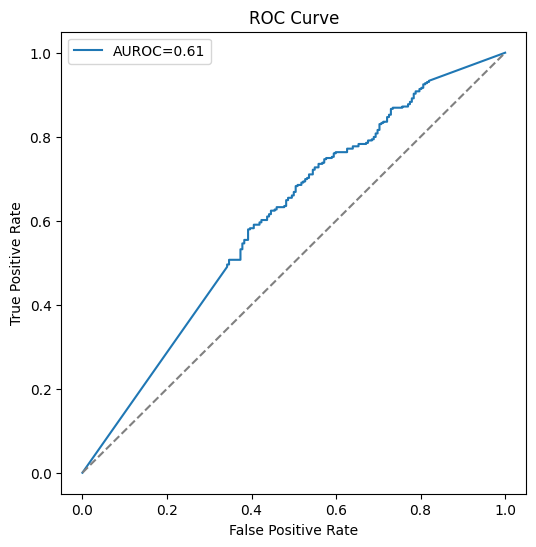

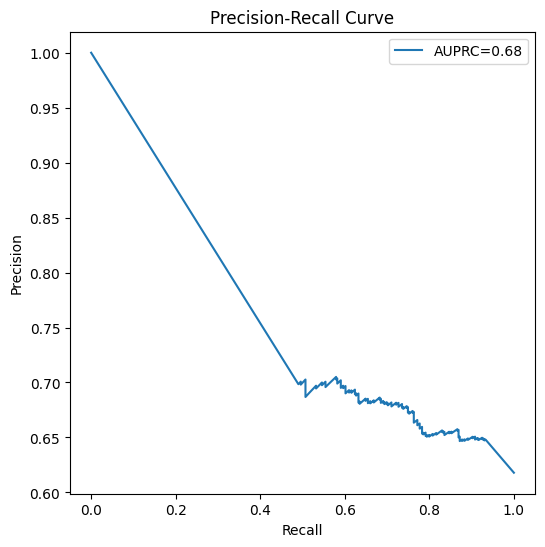

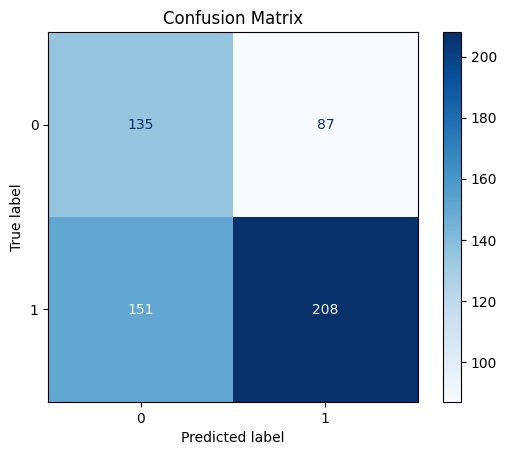

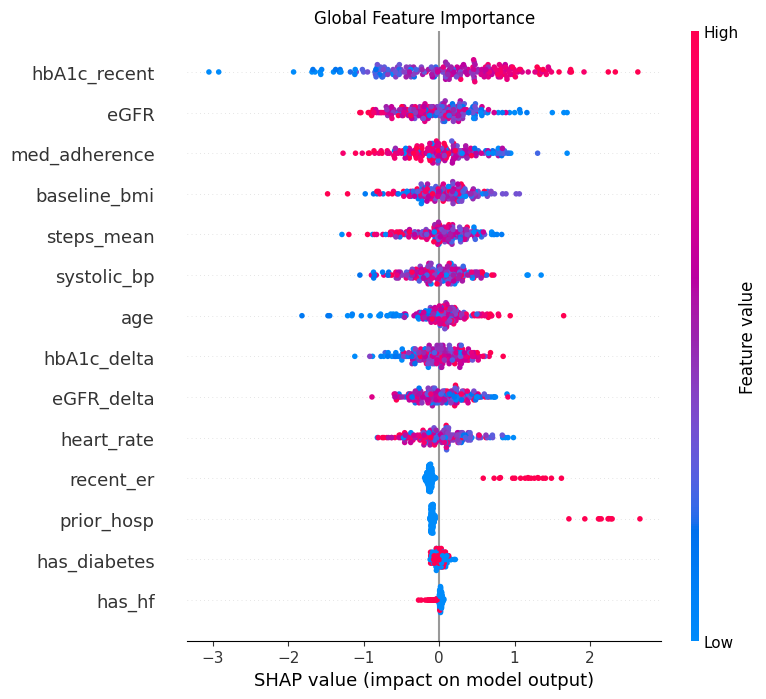

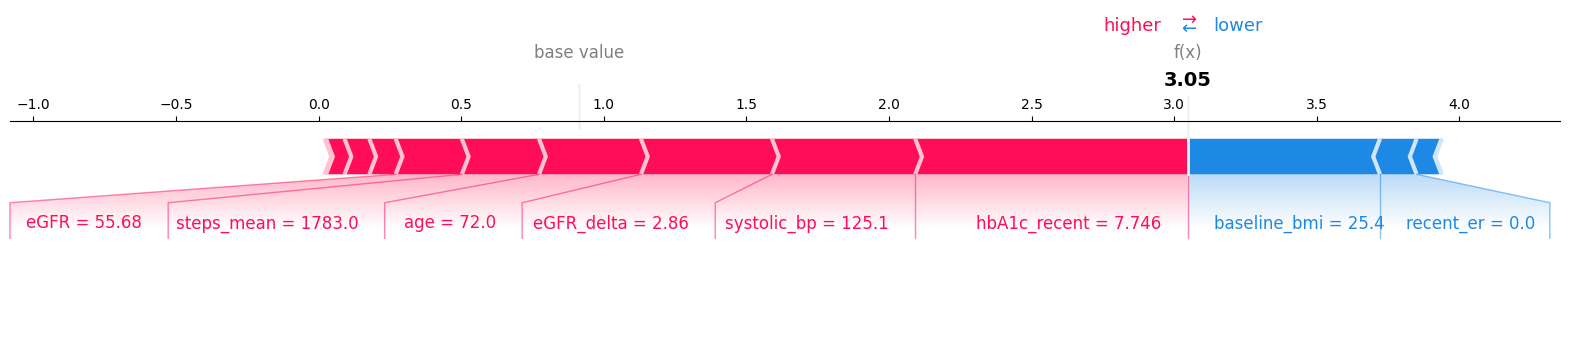

In [21]:

# Get the predictions and probabilities from the LightGBM model
probs_lgb = calibrator.predict_proba(X_test)[:,1]
# Use the best threshold determined in cell Kyoc4DztD4WU
preds_lgb = (probs_lgb >= best_thresh).astype(int)

# Use the evaluate_and_plot function to visualize the metrics
# Pass the LightGBM model to the function for SHAP explanations
evaluate_and_plot(y_test, preds_lgb, probs_lgb, model_lgb, X_train)

In [22]:
# -----------------------------
# 5. Explainability
# -----------------------------
use_shap = False
try:
    import shap
    # try to build explainer for HistGradientBoostingClassifier
    try:
        explainer = shap.Explainer(model)
        # reduce size to avoid heavy compute on large test sets
        shap_vals = explainer(X_test.sample(min(200, len(X_test)), random_state=0))
        use_shap = True
        print("SHAP available: using SHAP for explanations.")
    except Exception:
        use_shap = False
except Exception:
    use_shap = False

if use_shap:
    # Global importance
    shap_arr = np.abs(shap_vals.values).mean(axis=0)
    shap_df = pd.DataFrame(shap_arr, index=X_test.columns, columns=["mean_abs_shap"]).sort_values("mean_abs_shap", ascending=False)
    shap_df.head(10).to_csv(os.path.join(OUTPUT_DIR,"shap_global_top10.csv"))
    # plot top 10
    shap_df.head(10).plot.barh(figsize=(6,4))
    plt.gca().invert_yaxis()
    plt.title("SHAP mean |value| (global) - top 10")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,"shap_global_top10.png"))
    plt.close()
    # Local waterfall for a sample
    sample_idx = X_test.index[0]
    # If shap.plots available, attempt waterfall
    try:
        shap.plots.waterfall(shap_vals[0], show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR,"shap_waterfall_sample.png"))
        plt.close()
    except Exception:
        pass
else:
    # Permutation importance (fast: fewer repeats)
    print("SHAP not available. Using permutation importance (fallback).")
    r = permutation_importance(calibrator, X_test, y_test, n_repeats=8, random_state=0, n_jobs=1)
    perm_df = pd.DataFrame({"feature": X_test.columns, "importance_mean": r.importances_mean}).sort_values("importance_mean", ascending=False)
    perm_df.head(10).to_csv(os.path.join(OUTPUT_DIR,"perm_importance_top10.csv"), index=False)
    plt.figure(figsize=(6,4))
    perm_df.head(10).set_index("feature")["importance_mean"].plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Permutation importance (global) - top 10")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,"perm_importance_top10.png"))
    plt.close()
    # Local heuristic contributions for a sample: (value - mean) * normalized importance
    global_imp = perm_df.set_index("feature")["importance_mean"].reindex(X_test.columns).fillna(0.0)
    global_imp_norm = global_imp / (global_imp.sum() if global_imp.sum()>0 else 1.0)
    feature_means = X_train.mean()
    sample_idx = X_test.index[0]
    sample = X_test.loc[sample_idx]
    contribs = (sample - feature_means) * global_imp_norm
    contribs = contribs.sort_values(ascending=False)
    contribs.to_csv(os.path.join(OUTPUT_DIR,"local_contribs_heuristic_sample.csv"))


SHAP available: using SHAP for explanations.


Generating SHAP summary plot...


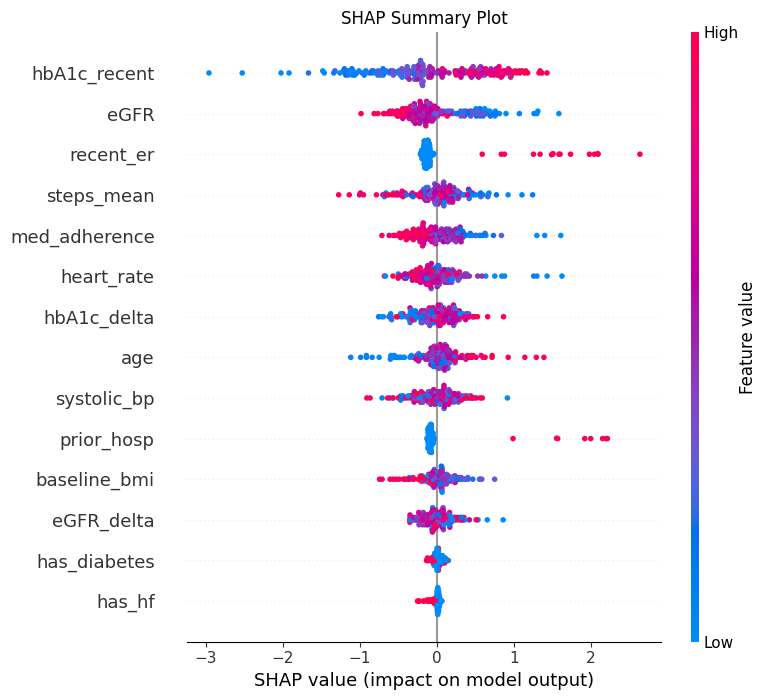

Generating SHAP waterfall plot for a sample...


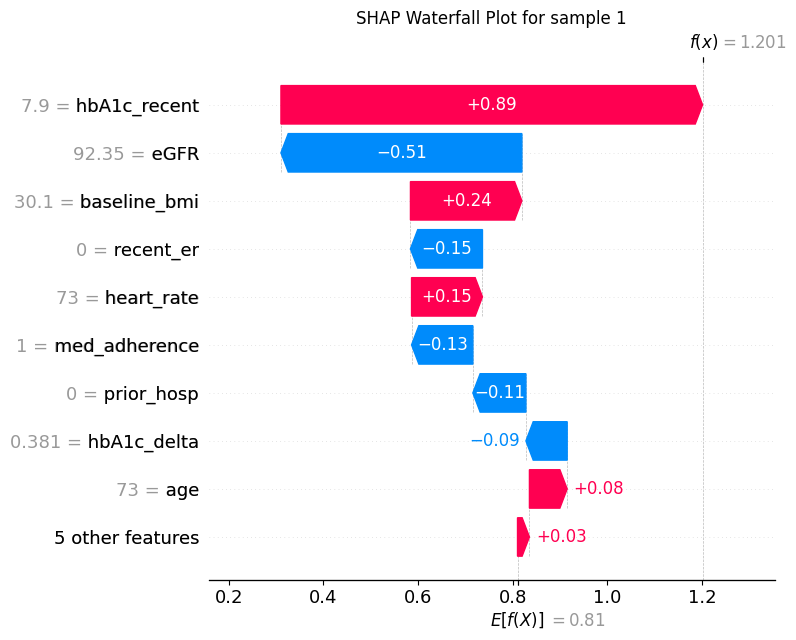

In [23]:
# Visualize SHAP results
if use_shap:
    # Global summary plot
    print("Generating SHAP summary plot...")
    plt.figure(figsize=(8, 7)) # Adjust size for better visibility
    shap.summary_plot(shap_vals, X_test.sample(min(200, len(X_test)), random_state=0), show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,"shap_summary_plot.png"))
    plt.show()

    # Local waterfall plot for a sample
    print("Generating SHAP waterfall plot for a sample...")
    try:
        sample_idx_to_explain = 0 # Explain the first sample in X_test
        shap.plots.waterfall(shap_vals[sample_idx_to_explain], show=False)
        plt.title(f"SHAP Waterfall Plot for sample {X_test.index[sample_idx_to_explain]}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR,"shap_waterfall_plot_sample.png"))
        plt.show()
    except Exception as e:
        print(f"Could not generate waterfall plot: {e}")

else:
    print("SHAP is not available, skipping SHAP visualizations.")

In [24]:
# -----------------------------
# 6. Helper: prediction + explanation function
# -----------------------------
def explain_prediction_for_snapshot(model_calibrated, X_snapshot: pd.DataFrame, topk=5):
    """
    Returns probability and a readable explanation for each snapshot row.
    If SHAP available use it; otherwise heuristic.
    """
    probs_local = model_calibrated.predict_proba(X_snapshot)[:,1]
    results = []
    # prepare global importances for heuristic
    if use_shap:
        # prepare approx global importance
        global_imp = pd.Series(np.abs(shap_vals.values).mean(axis=0), index=X_test.columns)
        global_imp_norm = global_imp / (global_imp.sum() if global_imp.sum()>0 else 1.0)
    else:
        global_imp_norm = global_imp if 'global_imp' in globals() else pd.Series(1.0/len(X_snapshot.columns), index=X_snapshot.columns)
    feat_means = X_train.mean()
    for i, idx in enumerate(X_snapshot.index):
        row = X_snapshot.loc[idx]
        p = float(probs_local[i])
        contribs = (row - feat_means) * global_imp_norm
        contribs_sorted = contribs.sort_values(ascending=False)
        pos = [f"{feat} ({row[feat]:.3f} vs mean {feat_means[feat]:.3f})" for feat in contribs_sorted.head(topk).index]
        neg = [f"{feat} ({row[feat]:.3f} vs mean {feat_means[feat]:.3f})" for feat in contribs_sorted.tail(topk).index]
        results.append({
            "index": idx,
            "probability": p,
            "top_positive_drivers": pos,
            "top_protective_factors": neg
        })
    return results

# Demo explanations for first 3 test snapshots
demo = explain_prediction_for_snapshot(calibrator, X_test.head(3))
pd.DataFrame(demo).to_csv(os.path.join(OUTPUT_DIR,"demo_explanations_sample.csv"), index=False)
print("Demo explanations saved.")

Demo explanations saved.


In [25]:
# -----------------------------
# 7. Save run summary & artifacts
# -----------------------------
summary = {
    "n_snapshots": len(df),
    "n_patients": df["patient_id"].nunique(),
    "train_snapshots": len(X_train),
    "test_snapshots": len(X_test),
    "auroc": auroc,
    "auprc": auprc,
    "brier": brier,
    "positive_rate_test": float(y_test.mean())
}
pd.Series(summary).to_csv(os.path.join(OUTPUT_DIR,"run_summary.csv"))

print("Artifacts written to:", OUTPUT_DIR)
print("Files:", os.listdir(OUTPUT_DIR))


Artifacts written to: ./outputs
Files: ['shap_waterfall_plot_sample.png', 'pr_curve_lgb.png', 'pr_curve.png', 'model_lgb_raw.joblib', 'shap_summary.png', 'calibration_curve_lgb.png', 'evaluation_metrics_lgb.csv', 'confusion_matrix.png', 'demo_explanations_sample.csv', 'confusion_matrix_lgb.png', 'shap_waterfall_sample.png', 'roc_curve.png', 'model_lgb_calibrated.joblib', 'roc_curve_lgb.png', 'shap_global_top10.csv', 'feature_importance_lgb.png', 'run_summary.csv', 'shap_summary_plot.png', 'shap_global_top10.png']
